Imports

In [1]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np

Simulation of 4 cars with a front car with constant velocity plus a sin function and $b=0.2,c=0.2, T=3$.

In [2]:
#Defining variables
# Define number of cars including the leader.
#number_of_cars = 2
constant_leading_speed,omega, amplitude = 28, 2, 1
number_of_cars = 4 
b,c=1.6,1.6
T=3
# Defining constants for adjusted acceleration
c1,c2,c3,c4 = -1,1,-10,10
k,l = 10, 0.25
adjusted_acceleration = True
# Defining starting positions
position = [[30*i] for i in range(number_of_cars)]
velocity = [[28] for i in range(number_of_cars)]
#position = [[2],[0]]
# position = [[84],[56],[28],[0]]
#velocity = [[2],[2]]
# velocity = [[28],[28],[28],[28]]
relative_position = []
for i in range(number_of_cars-1):
    relative_position.append([])
    relative_position[i].append(position[i][0]-position[i+1][0])

Formular for speed of leading car and accelaration:

In [3]:
#Speed of leading car
def v_f(c,t,omega,amplitude_local):
    return c+amplitude_local*np.cos(omega*t)

#Defining the accelaration function by the PD controller
def acc(d,v_self,v_front,T_local):
    return b*(v_front-v_self)+c*(d-v_front*T_local)

#Defining adjusted accelaration function
# c1 is the lower limit of the 'rate-zero'. 
# c2 is the upper limit of the 'rate-zero'. 
# c3 is the lower limit, where the acceleration becomes constant.
# c4 is the upper limit, where the acceleration becomes constant.
def acc_adj(a, c1, c2, c3, c4, k, l):
    f = 1/2 * (2 + np.tanh(k * (a - c2)) - np.tanh(k * (a - c1)))
    g = f * (1/2 * ((c4 - c3) * np.tanh(l * a) + (c4 + c3)))
    return g


Simulation code using eulers method.

In [4]:
time_steps = 100000
time_period = 120
step_size = time_period/time_steps

# Using eulers method
for i in range(time_steps):
    for j in range(number_of_cars):
        position[j].append(position[j][i] + velocity[j][i]*step_size)
        if j != 0:
            relative_position[j-1].append(position[j-1][i] - position[j][i])
        if j == 0:
            velocity[j].append(v_f(constant_leading_speed,(i*step_size),omega,amplitude))
        else:
            if adjusted_acceleration:
                a_temp = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                a = acc_adj(a_temp,c1,c2,c3,c4,k,l)
            else:
                a = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
            velocity[j].append(velocity[j][i] + a*step_size)

Plotting

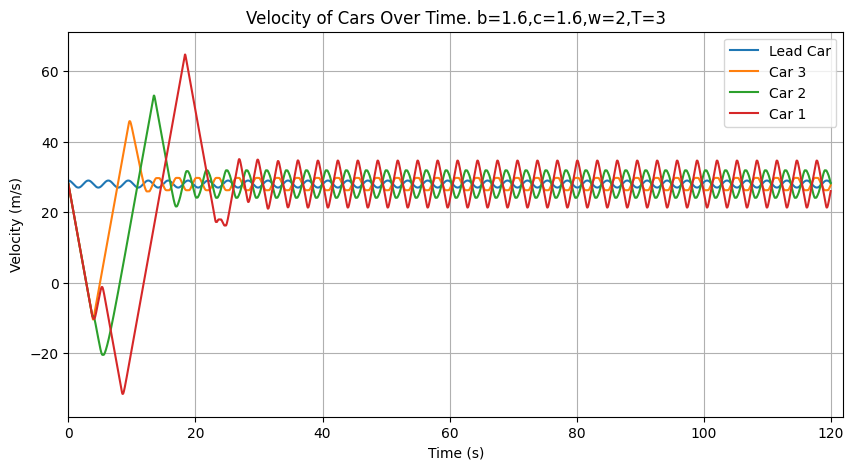

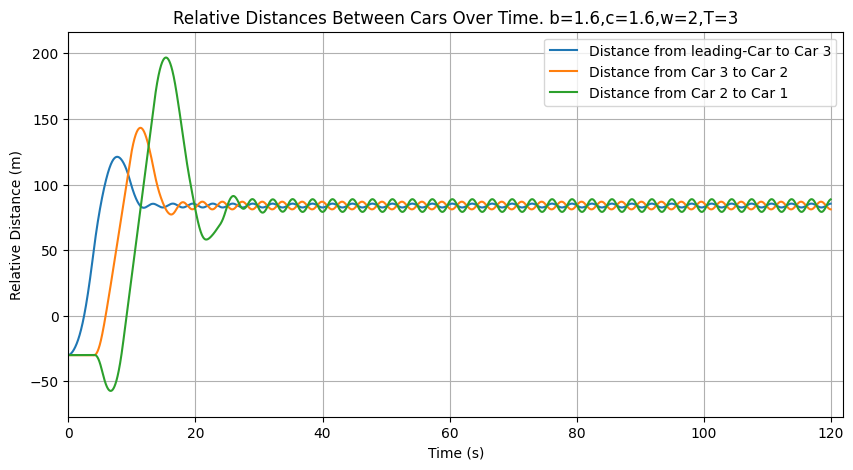

In [6]:
# Create time array
time = [i * step_size for i in range(time_steps+1)]

# Plot velocities
plt.figure(figsize=(10, 5))
for i in range(number_of_cars):
    if i == 0:
        plt.plot(time, velocity[i], label="Lead Car")
    else:
        plt.plot(time, velocity[i], label="Car "+str(number_of_cars-i))
plt.title(f"Velocity of Cars Over Time. b={b},c={c},w={omega},T={T}")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.xlim(0, time_period+2) 
plt.ylim(min(min(row) for row in velocity)-0.1*max(max(row) for row in velocity), 1.1*max(max(row) for row in velocity))  

plt.show()
plt.show()

# Plot relative distances
plt.figure(figsize=(10, 5))
for i in range(number_of_cars-1):
    if i == 0:
        plt.plot(time, relative_position[i], label="Distance from leading-Car to Car "+str(number_of_cars-1))
    else:
        plt.plot(time, relative_position[i], label="Distance from Car "+str(number_of_cars-i)+" to Car "+str(number_of_cars-i-1)) 
plt.title(f"Relative Distances Between Cars Over Time. b={b},c={c},w={omega},T={T}")
plt.xlabel("Time (s)")
plt.ylabel("Relative Distance (m)")
plt.legend()
plt.grid(True)
plt.xlim(0, time_period+2) 
plt.ylim(min(min(row) for row in relative_position)-0.1*max(max(row) for row in relative_position), 1.1*max(max(row) for row in relative_position))  

plt.show()


Plotting a_adjusted against a:

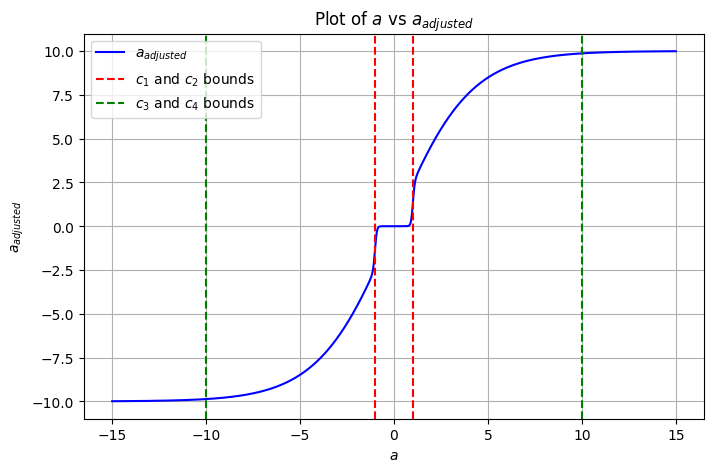

In [12]:
# Generate data for a
a_values = np.linspace(-15, 15, 5000)
a_adjusted = acc_adj(a_values, c1, c2, c3, c4, k, l)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(a_values, a_adjusted, label='$a_{adjusted}$', color='blue')

# Add vertical lines
plt.axvline(c1, color='red', linestyle='--', label='$c_1$ and $c_2$ bounds')
plt.axvline(c2, color='red', linestyle='--')
plt.axvline(c3, color='green', linestyle='--', label='$c_3$ and $c_4$ bounds')
plt.axvline(c4, color='green', linestyle='--')

# Additional plot details
plt.title('Plot of $a$ vs $a_{adjusted}$')
plt.xlabel('$a$')
plt.ylabel('$a_{adjusted}$')
plt.legend()
plt.grid(True)
plt.show()